In [1]:
# load training loss
from matplotlib import pyplot as plt
from tifffile import imread
from lpu3dnet import init_yaml
import numpy as np
import pickle

def read_pickle(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

def tif_to_np(f_name):
    '''
    convert tif to numpy
    '''
    img = imread(f_name)
    img = img.astype('float32')/255
    return img>0.5

experiment_idx = 2
epoch = 15
train_loss = read_pickle(f'ex{experiment_idx}/training_losses_epoch_{epoch}.pkl')

In [2]:
training_hours = train_loss['time'][-1].seconds /(60*60)
print('Total training time: {:.2f} hours'.format(training_hours))

Total training time: 2.68 hours


In [3]:
train_loss.keys()

dict_keys(['q_loss', 'rec_loss', 'd_loss', 'g_loss', 'total_loss', 'total_loss_per_epoch', 'perplexity', 'time'])

In [7]:
train_loss['q_loss'][-10:]

[0.01184048317372799,
 0.011634926311671734,
 0.011042347177863121,
 0.010983900167047977,
 0.016080569475889206,
 0.014074774459004402,
 0.010417957790195942,
 0.012480339966714382,
 0.011678166687488556,
 0.011483010835945606]

#### Plot current training history

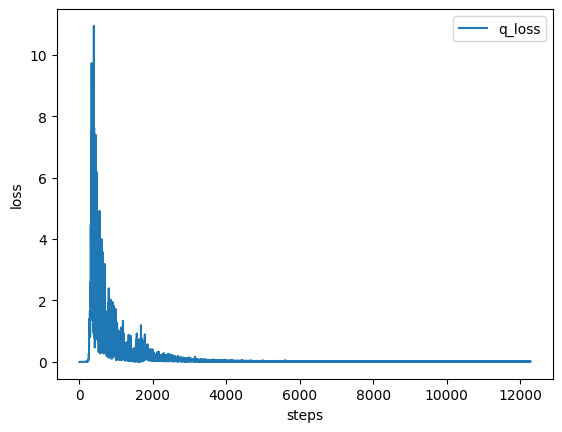

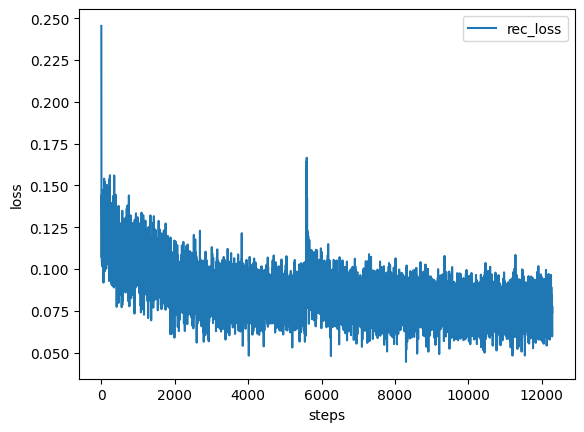

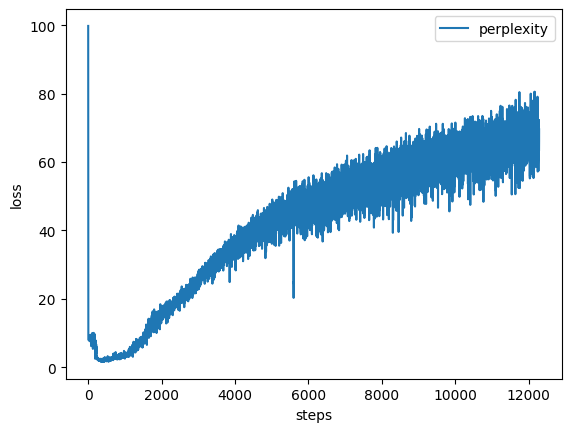

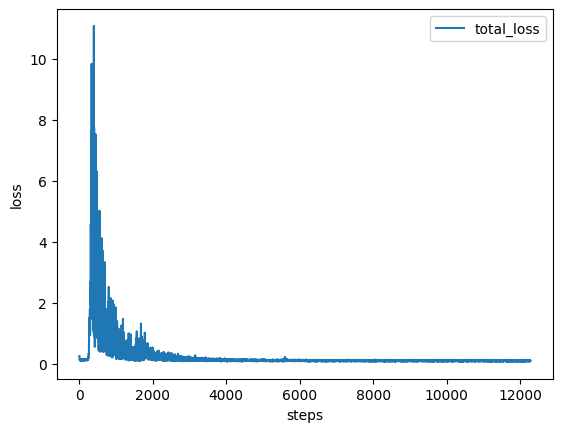

In [5]:
# train_loss.keys()
f=plt.figure()
plt.plot( range(len(train_loss['q_loss'])), train_loss['q_loss'], label='q_loss')
plt.xlabel('steps')
plt.ylabel('loss')
plt.legend()

f=plt.figure()
plt.plot( range(len(train_loss['rec_loss'])), train_loss['rec_loss'], label='rec_loss')
plt.xlabel('steps')
plt.ylabel('loss')
plt.legend()

f=plt.figure()
plt.plot( range(len(train_loss['perplexity'])), train_loss['perplexity'], label='perplexity')
plt.xlabel('steps')
plt.ylabel('loss')
plt.legend()


# f=plt.figure()
# plt.plot(range(steps), train_loss['g_loss'], label='g_loss')
# plt.xlabel('steps')
# plt.ylabel('loss')
# plt.legend()

# f=plt.figure()
# plt.plot(range(steps), train_loss['d_loss'], label='d_loss')
# plt.xlabel('steps')
# plt.ylabel('loss')
# plt.legend()

f=plt.figure()
plt.plot(range(len(train_loss['total_loss'])), train_loss['total_loss'], label='total_loss')
plt.xlabel('steps')
plt.ylabel('loss')
plt.legend()

# f=plt.figure()
# alpha = 0.8
# plt.plot(range(steps), train_loss['total_loss'], label='total_loss',alpha=alpha)
# plt.plot(range(steps), train_loss['g_loss'], label='g_loss',alpha=alpha)
# plt.plot(range(steps), train_loss['rec_loss'], label='rec_loss',alpha=alpha)
# plt.plot(range(steps), train_loss['vq_loss'], label='vq_loss',alpha=alpha)
# plt.xlabel('steps')
# plt.ylabel('loss')
# plt.legend()


#### Load the model - check image quanlity

In [6]:
# load pytorch model
import torch
from lpu3dnet.frame import vqgan

# get the global path
PATH = init_yaml.config_vqgan['data']['PATH']['sub_vol']

def get_img_list(idx_list,ct_idx):
    # input: ct image idx
    # output: list of images
    img_list = []
    for idx in idx_list:
        img = tif_to_np(f'{PATH}/ct_{ct_idx}/{idx}.tif')
        img_list.append(img)
    return img_list

def img_list_to_np(img_list):
    # input: list of images
    # output: numpy array of images
    image = np.stack(img_list,axis=0)
    return image

def idx_to_matrix(ct_idx,img_idx_list):
    # input: ct image idx, list of image idx
    # output: numpy array of images
    img_list = get_img_list(img_idx_list,ct_idx)
    img_matrix = img_list_to_np(img_list)
    img_matrix = img_matrix[:,np.newaxis,...]
    img_tensor = torch.from_numpy(img_matrix).float()

    return img_tensor,img_matrix


def tensor_to_np(tensor):
    # input: tensor
    # output: numpy array
    return tensor.detach().numpy()

model_vqgan = vqgan.VQGAN()

model_vqgan.load_state_dict(
    torch.load(
            f'ex{experiment_idx}/vqgan_epoch_{epoch}.pth',
               map_location=torch.device('cpu')
               )
    )

model_vqgan.eval()

VQGAN(
  (encoder): Encoder(
    (model): Sequential(
      (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): ResidualBlock(
        (block): Sequential(
          (0): GroupNorm(
            (gn): GroupNorm(16, 16, eps=1e-06, affine=True)
          )
          (1): Swish()
          (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): GroupNorm(
            (gn): GroupNorm(16, 16, eps=1e-06, affine=True)
          )
          (4): Swish()
          (5): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        )
      )
      (2): ResidualBlock(
        (block): Sequential(
          (0): GroupNorm(
            (gn): GroupNorm(16, 16, eps=1e-06, affine=True)
          )
          (1): Swish()
          (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): GroupNorm(
            (gn): GroupNorm(16, 16, eps=1e-06, affine=True)
          )
  

In [7]:
ct_idx = 0

img_idx = [0,100,200,300,400,500]

img_tensor,img_matrix = idx_to_matrix(ct_idx,img_idx)

with torch.no_grad():
    decode_img,codebook_indice,_ = model_vqgan(img_tensor)
decode_img = tensor_to_np(decode_img)

In [8]:
def compare_images(generated_images, original_images):
    """
    Display a comparison of generated images to original images
    :param generated_images: numpy array of shape (n, 1, 64, 64, 64)
    :param original_images: numpy array of shape (n, 1, 64, 64, 64)
    """
    
    # Ensure the shapes of the two image arrays are the same
    assert generated_images.shape == original_images.shape, "The generated images and original images should have the same shape."

    n = generated_images.shape[0]  # number of images
    
    # Create a figure
    fig, axes = plt.subplots(n, 2, figsize=(10, 5 * n))
    
    for i in range(n):
        # For single row subplot adjustment
        if n == 1:
            ax_gen = axes[0]
            ax_orig = axes[1]
        else:
            ax_gen = axes[i, 0]
            ax_orig = axes[i, 1]

        # Display generated image
        ax_gen.imshow(generated_images[i,0,0,::], cmap='gray')
        ax_gen.set_title(f'Generated Image {i+1}')
        ax_gen.axis('off')

        # Display original image
        ax_orig.imshow(original_images[i,0,0,::], cmap='gray')
        ax_orig.set_title(f'Original Image {i+1}')
        ax_orig.axis('off')
    
    plt.tight_layout()
    plt.show()

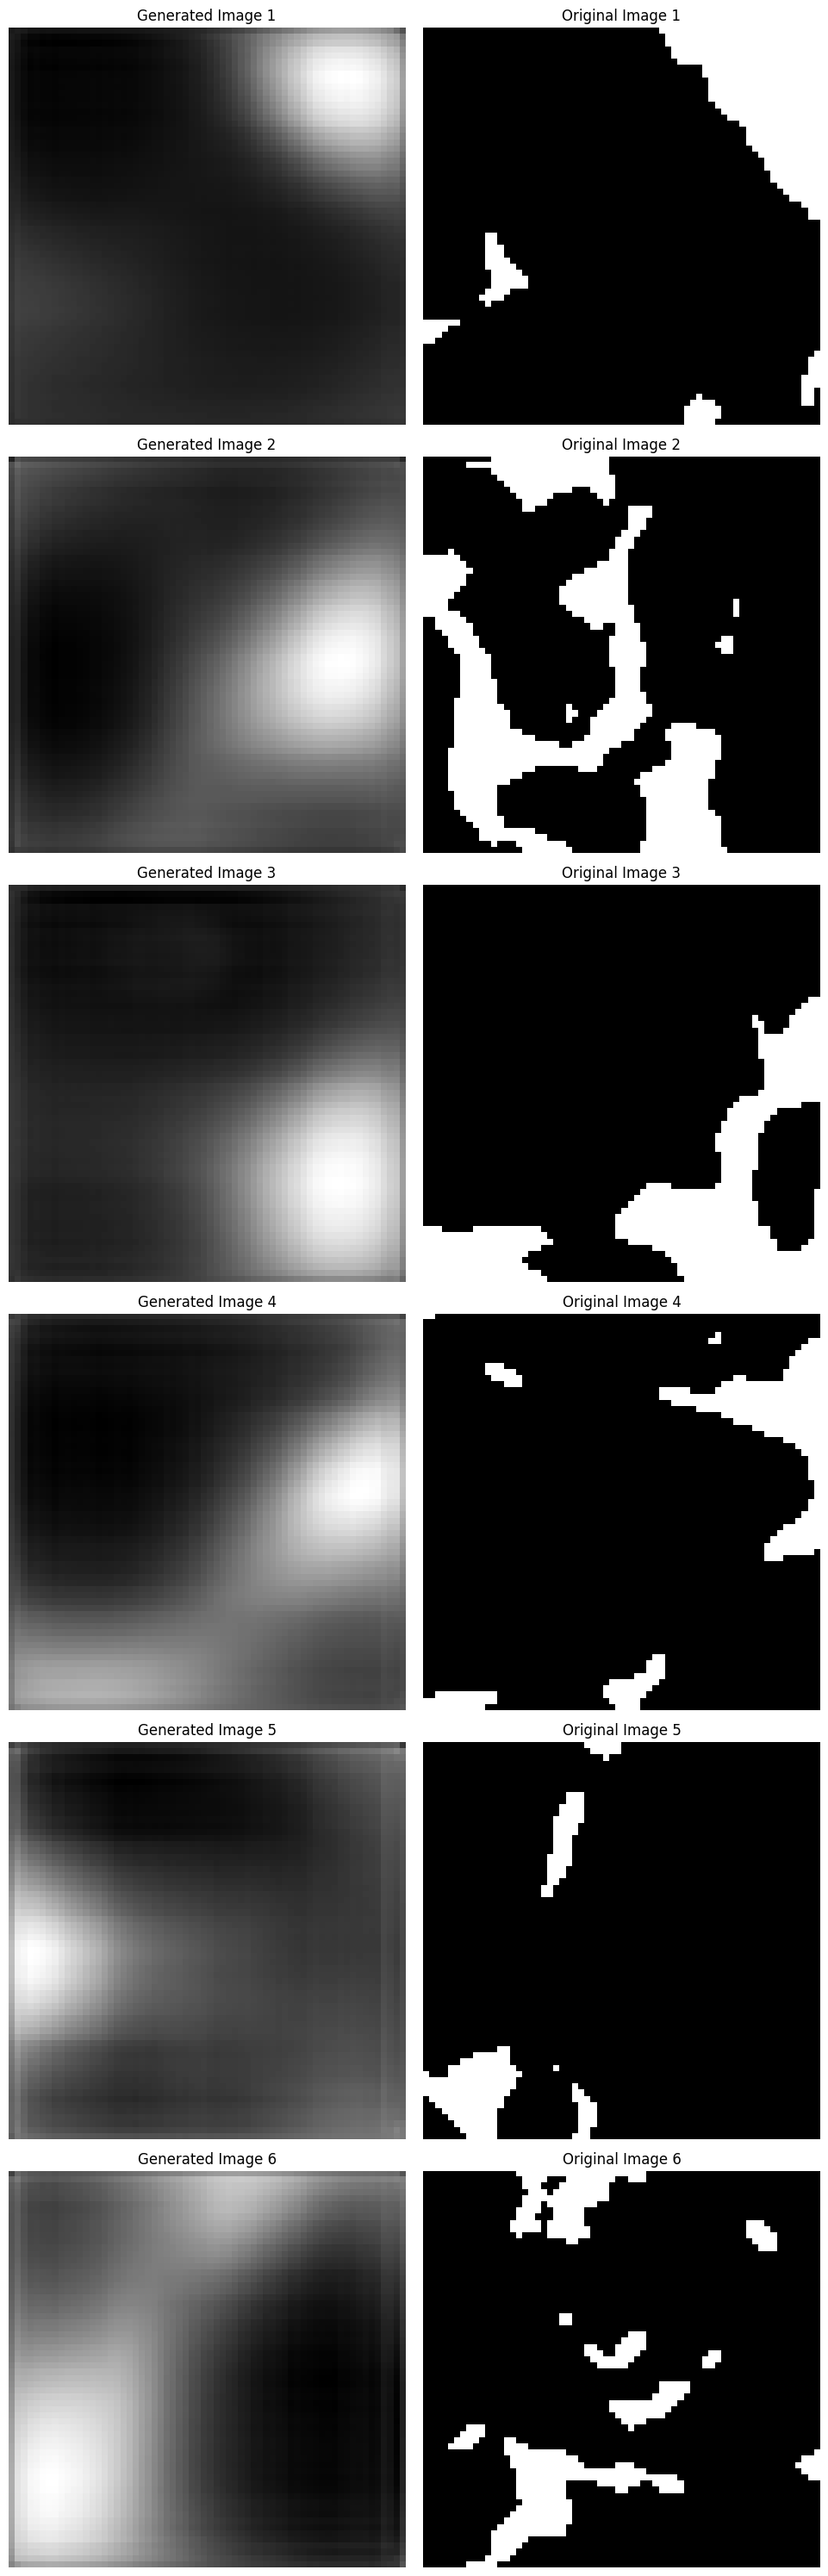

In [9]:
compare_images(decode_img,img_matrix)